# dotto

> A workspace for a directed graph based approach to the Colonel Blotto game, named Colonel Dotto.

In [1]:
#| default_exp dotto

I was struck by a moment of inspiration at around 1:30am on Tuesday 10/11/22. I want to hark back to something Professor Haddock told me during my exploration of the Colonel Blotto problem during the fall semester of my freshman year, which was to have fun with the research question and ask fundamental questions. These were questions such as given a strategy is there always a minimal change to "improve" a strategy. This can be represented in a directed graph by having the allocations to  the castle in a game be represented as a tuple; this tuple will be used as the graph weights for the graphs nodes. Each graph node will represent an individual strategy for the game. I was initially considering the edges to be unweighted because the weighted context did not arise naturally until now. That being, let the weight of an edge from one node to it's dominating node be $\sum\limits_{i=1}^{\text{\# of castles}}v_i * ?t_i$, where $v_i$ is the value of the $i$ th castle (which could possibly be weighted by how many extra troops the dominating strategy won by at that castle).

I returned to this on 11/30/22. Let's do some damage, using graphs!

In [25]:
import networkx as nx
import matplotlib.pyplot as plt


def preprocess_document(document, sentence_spliter='.', word_spliter=' ', punct_mark=','):
    # lowercase all words and remove trailing whitespaces
    document = document.lower().strip()
    
    # remove unwanted punctuation marks
    for pm in punct_mark:
        document = document.replace(pm, '')
    
    # get list of sentences which are non-empty
    sentences = [sent for sent in document.split(sentence_spliter) if sent != '']
    
    # get list of sentences which are lists of words
    document = []
    for sent in sentences:
        words = sent.strip().split(word_spliter)
        document.append(words)
        
    return document

def get_entities(document):
    # in our case, entities are all unique words
    unique_words = []
    for sent in document:
        for word in sent:
            if word not in unique_words:
                unique_words.append(word)
    return unique_words

def get_relations(document):
    # in our case, relations are bigrams in sentences
    bigrams = []
    for sent in document:
        for i in range(len(sent)-1):
            # for every word and the next in the sentence
            pair = [sent[i], sent[i+1]]
            # only add unique bigrams
            if pair not in bigrams:
                bigrams.append(pair)
    return bigrams

def build_graph(doc):
    # preprocess document for standardization
    pdoc = preprocess_document(doc)
    
    # get graph nodes
    nodes = get_entities(pdoc)
    
    # get graph edges
    edges = get_relations(pdoc)
    
    # create graph structure with NetworkX
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G

def plot_graph(G, title=None):
    # set figure size
    plt.figure(figsize=(10,10))
    
    # define position of nodes in figure
    pos = nx.nx_agraph.graphviz_layout(G)

    # draw nodes and edges
    nx.draw_networkx(G, pos=pos, ax=None, with_labels=True)
    
    # get edge labels (if any)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    
    # draw edge labels (if any)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    # plot the title (if any)
    plt.title(title)
    
    plt.show()
    return

In [30]:
G = build_graph("Today is a beautiful day.")

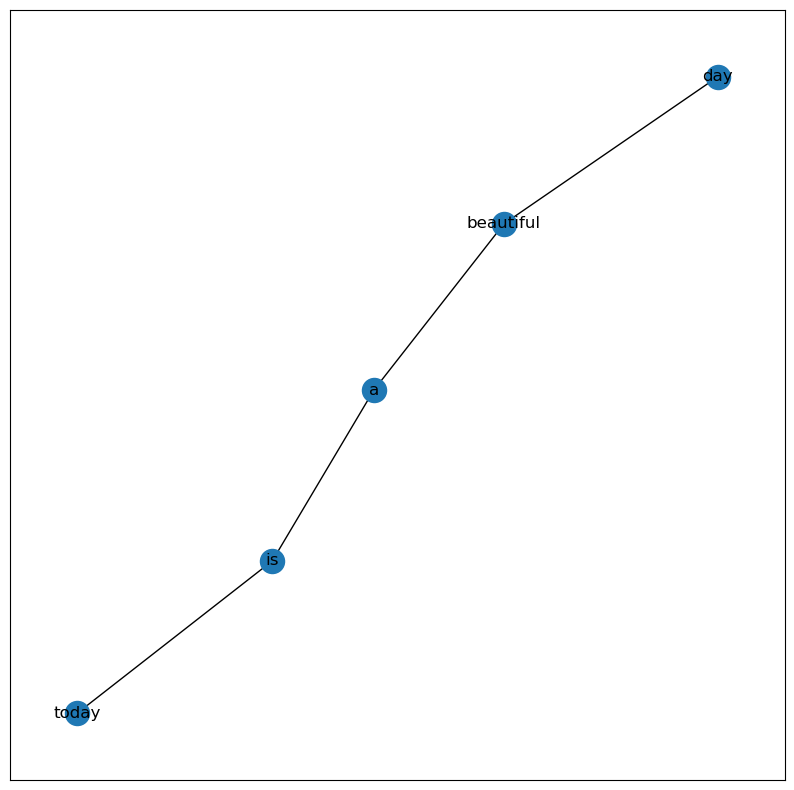

In [31]:
plot_graph(G)

In [55]:
import csv
import itertools

def sums(length, total_sum):
    if length == 1:
        yield (total_sum,)
    else:
        for value in range(total_sum + 1):
            for permutation in sums(length - 1, total_sum - value):
                yield (value,) + permutation

def game(player1, player2, numCastles):
    p1_score = 0
    p2_score = 0
    n = 0
    p1_wbt = 0
    p2_wbt = 0

    while p1_wbt < 3 and p2_wbt < 3 and n < numCastles:
        if player1[n] > player2[n]:
            p1_score += n + 1
            p1_wbt += 1
            p2_wbt = 0
        if player1[n] < player2[n]:
            p2_score += n + 1
            p2_wbt += 1
            p1_wbt = 0
        if player1[n] == player2[n]:
            p1_wbt = 0
            p2_wbt = 0
        n += 1

    while p1_wbt == 3 and n < numCastles:
        p1_score += n + 1
        n += 1
    while p2_wbt == 3 and n < numCastles:
        p2_score += n + 1
        n += 1

    if p1_score > p2_score:
        return 1
    if p1_score < p2_score:
        return -1
    if p1_score == p2_score:
        return 0
    
def tournament(numTroops, numCastles):
    strategies = list(sums(numCastles, numTroops))
    competitors = {}
    for allocation in strategies:
        competitors[allocation] = [0, 0, 0]
    file_data = []
    highest_score = 0
    gameMatrix = [[0 for i in range(len(strategies))] for j in range(len(strategies))]
    for i, player1 in enumerate(competitors):
        for j, player2 in enumerate(competitors):
            result = game(player1, player2, numCastles)
            gameMatrix[i][j] = result
            if result == 1:
                competitors[player1][0] += 1
                competitors[player2][1] += 1
            if result == -1:
                competitors[player2][0] += 1
                competitors[player1][1] += 1
            else:
                competitors[player1][2] += 1
                competitors[player2][2] += 1
    file_data.append(competitors)
    file_data.append(gameMatrix)
    filename = f"C{numCastles:02}-T{numTroops:03}.txt"

    with open(filename, "w") as fle:
        json.dump(file_data, fle)

def csvtournament(numTroops, numCastles):
    strategies = list(sums(numCastles, numTroops))
    competitors = {}
    for allocation in strategies:
        competitors[allocation] = [0, 0, 0]
    winners = []
    highest_score = 0
    gameMatrix = [[0 for i in range(len(strategies))] for j in range(len(strategies))] 
    for i, player1 in enumerate(competitors):
        for j, player2 in enumerate(competitors):
            result = game(player1, player2, numCastles)
            gameMatrix[i][j] = result
            if result == 1:
                competitors[player1][0] += 1 # Player 1 win
                competitors[player2][1] += 1 # Player 2 loss
            if result == -1:
                competitors[player2][0] += 1 # Player 2 win
                competitors[player1][1] += 1 # Player 1 loss
            if result == 0:
                competitors[player1][2] += 1 # tie
                competitors[player1][2] += 1 # tie
    all_scores = competitors.values()
    highest_score = max(all_scores)
    for player in competitors:
        if competitors[player] == highest_score:
            winners.append(player)
    print(gameMatrix)

    fields = ["win_percentile"]
    for i in range(1, numCastles + 1):
        fields.append("c" + str(i))
    rows = []
    for strategy in competitors:
        profile = [(competitors[strategy][0]/competitors[strategy][0] + competitors[strategy][1] + competitors[strategy][2])]
        for troops in strategy:
            profile.append(troops)
        rows.append(profile)
    filename = 'csvBlotto, numCastles = ' + str(numCastles) + ", numTroops =" + str(numTroops)

# writing to csv file
    with open(filename, 'w') as csvfile:
    # creating a csv writer object
        csvwriter = csv.writer(csvfile)

    # writing the fields
        csvwriter.writerow(fields)

    # writing the data rows
        csvwriter.writerows(rows)

def dottocsv(numTroops, numCastles):
    strategies = list(sums(numCastles, numTroops))
    competitors = {}
    competitors["source"] = []
    competitors["target"] = []

    unique = list(itertools.combinations(range(len(strategies)), r=2))
    
    for pair in unique:
        i = pair[0]
        j = pair[1]
        player1 = strategies[i]
        player2 = strategies[j]
    
        result = game(player1, player2, numCastles)

        if result == 1:
        # Player 1 win, Player 2 loss
            competitors["source"].append(j)
            competitors["target"].append(i)
        if result == -1:
        # Player 2 win, Player 1 loss
            competitors["source"].append(i)
            competitors["target"].append(j)
        #if result == 0:
        # Tie
        
    field_names = ["source", "target"]

    filename = f'C{numCastles}T{numTroops}'

# writing to csv file
    with open(filename, 'w') as csvfile:
        # creating a csv dictionary writer object
        writer = csv.DictWriter(csvfile, fieldnames=field_names)
        # writing the fields
        writer.writeheader()
        # writing the data rows
        writer.writerows([competitors])


In [56]:
dottocsv(3, 3)

In [57]:
import pandas as pd
df = pd.read_csv("./C3T3")
Graphtype = nx.Graph() 
Graph = nx.from_pandas_edgelist(df,"source", 'target', create_using=Graphtype)

ModuleNotFoundError: No module named 'pandas'